<a href="https://colab.research.google.com/github/wsimpso1/recent_projects/blob/main/NLP_Text_Summarization_War_In_Ukraine/Part_3_text_sum_ukraine_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Twitter Event Summarization: Making Sense of War in Ukraine
---
**Aishwarya Kale and William Simpson**  

Dept. of Computer Science & Electrical Engineering, University of Maryland, Baltimore County 

DATA 690: Introduction to Natural Language Processing 

Dr. Antonio Diana 

May 6, 2022

**Scroll down to see the beginning of Part 3**

# Install Necessary Libraries

In [ ]:
!pip install -q bertopic
!pip install -q python-louvain
!pip install -q -U sentence-transformers
!pip install -q transformers
!pip install -q rouge
!pip install -q emoji
!pip install -q pandarallel 
!pip install -q sumy
!pip install -q textrank4zh
!pip install -q textstat

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt') 
from datetime import datetime, timedelta
import ast

# ner
from spacy import displacy
import emoji
import string

# topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from bertopic import BERTopic

# clustering
from sklearn.metrics.pairwise import linear_kernel
from tqdm.notebook import tnrange
import networkx as nx
import community.community_louvain as community_louvain
from sentence_transformers import SentenceTransformer, util
import umap
import hdbscan
from bertopic import BERTopic
from gensim.summarization import keywords
from wordcloud import WordCloud

# sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob as tb
nltk.download('vader_lexicon')
from pandarallel import pandarallel

# summarization
from transformers import pipeline
from rouge import Rouge 
from statistics import mean
import seaborn as sns
import math
from collections import Counter
from nltk.probability import FreqDist
from sentence_transformers.util import cos_sim as cos_sim_
import transformers
from transformers import BartTokenizer, BartForConditionalGeneration
import textwrap
from gensim.summarization import summarize
from spacy.lang.en.stop_words import STOP_WORDS
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from string import punctuation
from heapq import nlargest
import sys
from textrank4zh import TextRank4Sentence
import textstat

# settings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=DeprecationWarning)
import multiprocessing
# check number of cores available
print('\nNUMBER OF CPU CORES:', multiprocessing.cpu_count())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

NUMBER OF CPU CORES: 4


# Data Preparation

IMPORTANT:

1) The filepath may need to be changed to point to the location of the datafile.\
2) The lineterminator='\n' parameter is necessary to ensure Pandas reads the file correctly.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load original data file for custom preprocessing in NER and Sentiment Analysis
tweets_original = pd.read_csv('/content/drive/MyDrive/Ukraine_war.csv')

# load cleaned data 
tweets = pd.read_csv('/content/drive/MyDrive/ukraine_war_clean_.csv', lineterminator='\n')

In [ ]:
# convert to datetime object
tweets.date = pd.to_datetime(tweets.date)

--- 
---
# Part 3. Evaluation of Summarization

### 3.1 Abstractive Summaries Evaluation with Similarity Metrics

#### Load generated abstractive summaries of 5 days.



In [ ]:
# reading all csv files as pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/Latest_Transfomer_summary.csv')

In [ ]:
abstract_summaries = df.copy()

In [ ]:
def clean_summary(text2):
  text2 = text2.replace('summary_text', '')
  text2= re.sub("[^A-Za-z0-9 .]", "", text2)
  return text2

abstract_summaries['trans_summary'] = abstract_summaries['trans_summary'].apply(clean_summary)

In [ ]:
abstract_summaries.drop(columns=['Unnamed: 0'],inplace=True)

#### Similarity Metrics: Count Vectorizer with Cosine Similarity

In [ ]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    words = WORD.findall(text)
    return Counter(words)

df = abstract_summaries.copy()
df['vector1']=df['content_clean'].apply(lambda x: text_to_vector(x)) 
df['vector2']=df['trans_summary'].apply(lambda x: text_to_vector(x)) 
abstract_summaries['cosine_similarity_CV']=df.apply(lambda x: get_cosine(x['vector1'],x['vector2']),axis=1)

In [ ]:
pd.set_option('max_colwidth', 100)
abstract_summaries.head()

,date,content_clean,counts,trans_summary,cosine_similarity_CV
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581


#### Similarity Metrics: TF-IDF with Cosine Similarity

In [ ]:
stopwords_en = stopwords.words ("english")
def preprocessing (raw):
  wordlist = nltk.word_tokenize (raw)
  text = [w.lower() for w in wordlist if w not in stopwords_en]
  return text

In [ ]:
def tf_idf(f1,f2):
  text1 = preprocessing(f1)
  text2 = preprocessing(f2)

  word_set = set(text1).union (set (text2))
  freqd_text1 = FreqDist (text1)
  text1_count_dict= dict.fromkeys (word_set, 0)
  for word in text1:
    text1_count_dict[word] = freqd_text1[word]

  freqd_text2 = FreqDist(text2)
  text2_count_dict= dict. fromkeys (word_set, 0)
  for word in text2:
    text2_count_dict[word] = freqd_text2 [word]

# IF calculations
  freqd_text1 = FreqDist(text1)
  text1_length = len (text1)
  text1_tf_dict = dict.fromkeys (word_set, 0)
  for word in text1:
    text1_tf_dict[word]= freqd_text1[word]/text1_length

  freqd_text2 = FreqDist (text2)  
  text2_length = len (text2)
  text2_tf_dict = dict.fromkeys (word_set, 0)
  for word in text2:
    text2_tf_dict [word]= freqd_text2[word]/text2_length

#IDF calculations
  text12_idf_dict = dict.fromkeys (word_set, 0)
  text12_length = 2 # 2 documents
  for word in text12_idf_dict.keys():
    if word in text1:
      text12_idf_dict[word] += 1
    if word in text2:
      text12_idf_dict [word] += 1

  import math
  for word, val in text12_idf_dict.items () :
    text12_idf_dict[word] = 1 + math.log(text12_length/ (float (val)))

# TF-IDF Calculations
  text1_tfidf_dict = dict. fromkeys (word_set, 0)
  for word in text1:
    text1_tfidf_dict[word] = (text1_tf_dict [word]) * (text12_idf_dict[word])

  text2_tfidf_dict = dict. fromkeys (word_set, 0)
  for word in text2:
    text2_tfidf_dict[word] = (text2_tf_dict[word]) * (text12_idf_dict[word])

  # Compute Cosine distance
  v1 = list (text1_tfidf_dict.values())
  v2 = list (text2_tfidf_dict.values ())
  similarity = 1 - nltk.cluster.cosine_distance (v1, v2)
  return similarity

In [ ]:
abstract_summaries['cosine_similarity_TFIDF']=abstract_summaries.apply(lambda x: tf_idf(x['content_clean'],x['trans_summary']),axis=1)

In [ ]:
abstract_summaries.head()

,date,content_clean,counts,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210,0.454151
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256,0.405783
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543,0.488659
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379,0.429205
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581,0.380874


#### Similarity Metrics: Using Sentence Transformers

In [ ]:
model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def bert_sent(text1,text2):
  embd_a = model.encode(text1)
  embd_b = model.encode(text2)

  sim_score = cos_sim_(embd_a, embd_b)

  return sim_score

In [ ]:
abstract_summaries['similarity_score_BERT']=abstract_summaries.apply(lambda x: bert_sent(x['content_clean'],x['trans_summary']),axis=1)

In [ ]:
abstract_summaries.tail()

,date,content_clean,counts,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF,similarity_score_BERT
0,2022-02-03,this sounds as if the united states under joe biden is making sssstuff up in order to provoke a...,3308,the admin seems to want war there might be a lot of things that would get lost or dead in the f...,0.441210,0.454151,[[tensor(0.8242)]]
1,2022-02-02,i stand firm western eu needs a reality check just about as bad as the dem establishment have u...,4324,i stand firm western eu needs a reality check just as bad as the dem establishment have ukraine...,0.392256,0.405783,[[tensor(0.8645)]]
2,2022-01-16,not real war but virtual conflict the ministry of digital development of ukraine all evidence in...,1253,the ministry of digital development of ukraine all evidence indicates that russia is behind the...,0.496543,0.488659,[[tensor(0.8430)]]
3,2022-01-15,globalists start another war 2022 russia ukraine usual suspects send troops including our true e...,1494,globalists start another war 2022 russia ukraine usual suspects send troops including our true ...,0.426379,0.429205,[[tensor(0.9595)]]
4,2022-02-27,i don t remember any war or any political issue with the entire world united on supporting ukrai...,4775,aek midfielder yevgen shakhov sent his message before the kickoff of the derby against panathin...,0.361581,0.380874,[[tensor(0.4994)]]


### 3.2 Extractive Summaries Evaluation with Similarity Metrics

#### Load generated extractive summaries of 5 days.


In [ ]:
extractive_summaries = pd.read_csv('/content/drive/MyDrive/extractive_summaries.csv')

In [ ]:
extractive_summaries = extractive_summaries.dropna()

#### Similarity Metrics: Count Vectorizer with Cosine Similarity

In [ ]:
df = extractive_summaries.copy()
df['vector1']=df['raw_content'].apply(lambda x: text_to_vector(x)) 
df['vector2']=df['trans_summary'].apply(lambda x: text_to_vector(x)) 
extractive_summaries['cosine_similarity_CV']=df.apply(lambda x: get_cosine(x['vector1'],x['vector2']),axis=1)

In [ ]:
del extractive_summaries['Unnamed: 0']
del extractive_summaries['Unnamed: 0.1']

In [ ]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692


#### Similarity Metrics: TF-IDF with Cosine Similarity

In [ ]:
extractive_summaries['cosine_similarity_TFIDF']=extractive_summaries.apply(lambda x: tf_idf(x['raw_content'],x['trans_summary']),axis=1)

In [ ]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692


#### Similarity Metrics: Using Sentence Transformers

In [ ]:
extractive_summaries['similarity_score_BERT']=extractive_summaries.apply(lambda x: bert_sent(x['raw_content'],x['trans_summary']),axis=1)

In [ ]:
extractive_summaries.head()

,date,content,raw_content,trans_summary,cosine_similarity_CV,cosine_similarity_TFIDF,similarity_score_BERT
0,2022-02-03,@JackPosobiec This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in ord...,This sounds as if The United States under Joe Biden is making ‘sssstuff’ up in order to provoke...,Learn more: Turkish citizen by d name Nuri Bozkir was EXTRAORDINARILY RENDITIONED4rm Ukraine ba...,0.741791,0.631312,[[tensor(0.5294)]]
1,2022-01-16,"Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of #Ukraine : ""All ev...","Not real war, but virtual conflict\n-\nThe Ministry of Digital Development of Ukraine : ""All evi...",Now we are talking about Biden going to War with Russia for Invading Ukraine?.In the Trenches of...,0.660931,0.591371,[[tensor(0.5777)]]
2,2022-01-15,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including 🇦🇺 Our ...,Globalists start another war 2022 Russia + Ukraine. Usual suspects send troops including Our tr...,Rather than urging war over Ukraine and its government we should be trying to reverse Brexit to ...,0.683883,0.638769,[[tensor(0.6937)]]
3,2022-02-27,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,I don't remember any war or any political issue with THE ENTIRE WORLD united on supporting ukrai...,Indian student wants to stay back in Ukraine 'till end of war' to look after landlord's family -...,0.763882,0.623692,[[tensor(0.5472)]]


## 3.3 Evaluation with ROUGE

### Visualize Frequency of Keywords (Example)


In [ ]:
# example with user defined keywords
keywords = ['pope', 'francis']
keywords = [word.lower() for word in keywords]
# get all tweets that contain all keywords
tweets_keyword = tweets.loc[tweets['tokenized'].apply(lambda x: all([y in x for y in keywords]))]

In [ ]:
# group tweets by day for visualization
tweets_keyword['date_day'] = pd.to_datetime(tweets_keyword['date']).dt.date
count_dates = tweets.content.groupby(tweets_keyword.date_day).count()

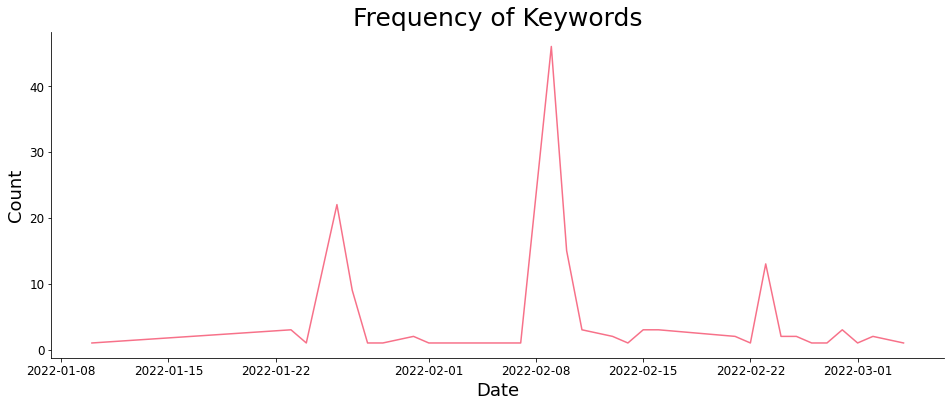

In [ ]:
# plot keyword frequency throughout corpus
plt.figure(figsize=(16,6))
sns.set_palette('husl')
fig = sns.lineplot(x=count_dates.index, y=count_dates.values, palette='rocket')
plt.title('Frequency of Keywords', fontsize=25)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.spines['right'].set_visible(False)
fig.spines['top'].set_visible(False)
plt.show()

### Tweet Selection from Keyword(s)

In [ ]:
keywords = [['pope', 'francis'],
            ['harris', 'poland'],
            ['invade', 'olympics'],
            ['fly', 'zone'],
            ['abramovich', 'chelsea'],
            ['nord', 'germany'],
            ['separatist', 'putin'],
            ['false', 'flag'],
            ['block', 'facebook'],
            ['biden', 'deploy']]

##### Sources for Reference Summaries

- pope francis: https://www.vaticannews.va/en/pope/news/2022-03/pope-francis-ukraine-war-inhuman-sacrilegious.html
- harris poland: https://www.cnn.com/2022/03/04/politics/kamala-harris-romania-poland/index.html
- nato join: https://www.washingtonpost.com/world/2022/02/01/what-is-nato-treaty-article-five-russia-ukraine/ 
- fly zone: https://abcnews.go.com/International/ukraine-fly-zone-option-experts/story?id=83164297 
- abramovich, chelsea: https://www.cnbc.com/2022/03/02/russian-oligarch-abramovich-says-he-will-sell-chelsea-soccer-club-amid-ukraine-furor.html 
- nord, germany: https://www.cnn.com/2022/02/22/business/nord-stream-2-germany-russia/index.html
- separatist, putin: https://www.pbs.org/newshour/politics/putin-recognizes-separatist-eastern-ukrainian-regions-paving-the-way-for-military-support  
- false, flag: https://www.pbs.org/newshour/world/u-s-intel-suggests-russia-is-plotting-false-flag-attack-in-ukraine-as-pretext-for-invasion
- block, facebook: https://www.theguardian.com/world/2022/mar/04/russia-completely-blocks-access-to-facebook-and-twitter 
- biden, deploy: https://abcnews.go.com/Politics/biden-orders-us-troop-deployments-reassure-nato-allies/story?id=82622507 

In [ ]:
ref_sum_ = [["Pope Francis calls the war in Ukraine an act of violent aggression and a sacrilege without justification, and appeals for an end to the violence and long-term welcome of Ukrainian refugees."],
            ["The White House confirmed Friday that Vice President Kamala Harris will pay a visit to NATO allies Poland and Romania next week"],
            ["Senior Chinese officials told senior Russian officials in early February not to invade Ukraine before the end of the Winter Olympics in Beijing"],
            ["Ukrainian officials under relentless attack from Russian forces have pleaded with President Joe Biden and members of NATO to impose a no-fly zone over significant parts of Ukraine."],
            ["Russian oligarch Roman Abramovich said he will sell the Chelsea soccer club in England, a dramatic move that comes in response to outrage over Russia’s invasion of Ukraine. Abramovich at the same time announced that he has instructed the renowned team to set up a foundation that will use all net proceeds from the sale of Chelsea to benefit all victims of the war in Ukraine."],
            ["Germany said it was halting certification of the Nord Stream 2 gas pipeline following Moscow's actions in eastern Ukraine on Monday."],
            ["Russian President Vladimir Putin on Monday recognized the independence of separatist regions in eastern Ukraine and paved the way to provide them military support — triggering threatened new sanctions from the U.S. and Europe and further fueling fears that Russia could imminently invade Ukraine."],
            ["U.S. intel suggests Russia is plotting false flag attack in Ukraine as pretext for invasion. The U.S. accused the Kremlin on Thursday of an elaborate plot to fabricate an attack by Ukrainian forces that Russia could use as a pretext to take military action against its neighbor. Pentagon spokesman John Kirby said the scheme included production of a graphic propaganda video that would show staged explosions and use corpses and actors depicting grieving mourners."],
            ["Russia has completely blocked access to Facebook in retaliation for the platform placing restrictions on state-owned media. The Russian state communications regulator, Roskomnadzor, later said it had also restricted access to Twitter."],
            ["President Joe Biden has ordered U.S. troop deployments to reassure NATO allies amid the standoff with Russia over Ukraine."]]
  
# clean reference summaries
ref_sum = []
punkt = ['.',',','_','/','-','–','—']
for i in ref_sum_:
  for j in i:
    j = j.split()
    j = [item.strip() for item in j if item.strip() not in punkt]
    j = " ".join([word.lower() for word in j])

    ref_sum.append(j)
ref_sum


['pope francis calls the war in ukraine an act of violent aggression and a sacrilege without justification, and appeals for an end to the violence and long-term welcome of ukrainian refugees.',
 'the white house confirmed friday that vice president kamala harris will pay a visit to nato allies poland and romania next week',
 'senior chinese officials told senior russian officials in early february not to invade ukraine before the end of the winter olympics in beijing',
 'ukrainian officials under relentless attack from russian forces have pleaded with president joe biden and members of nato to impose a no-fly zone over significant parts of ukraine.',
 'russian oligarch roman abramovich said he will sell the chelsea soccer club in england, a dramatic move that comes in response to outrage over russia’s invasion of ukraine. abramovich at the same time announced that he has instructed the renowned team to set up a foundation that will use all net proceeds from the sale of chelsea to benef

### Generate System Summaries

In [ ]:
# define abstractive summarizer - T5 Model
summarizer = pipeline("summarization", model="t5-small", tokenizer='t5-base', framework='tf')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
# generate summaries
sys_sum = []
for i in range(len(keywords)): 
  tweets_keyword = tweets.loc[tweets['tokenized'].apply(lambda x: all([y in x for y in keywords[i]]))]
  tweets_keyword = tweets_keyword[:400:4]
  combined_tweets = "".join([tweet for tweet in tweets_keyword['content_clean']])
  sum = summarizer(combined_tweets, max_length=200, min_length=25)
  sys_sum.append(sum)
  print(f'Completed Summary {i+1} of {len(keywords)}')
print('\n')
sys_sum = [sum_text[0]['summary_text'] for sum_text in sys_sum]
sys_sum

### Evaluate Summaries with Rouge

In [ ]:
# evaluate with Rouge-1
rouge_scores = []
rouge = Rouge()
for elem in range(len(keywords)):
  score = rouge.get_scores(sys_sum[elem], ref_sum[elem])
  rouge_scores.append(score)
rouge_scores

[[{'rouge-1': {'f': 0.3478260822600295,
    'p': 0.27906976744186046,
    'r': 0.46153846153846156},
   'rouge-2': {'f': 0.12499999531250018, 'p': 0.1, 'r': 0.16666666666666666},
   'rouge-l': {'f': 0.26086956052089905,
    'p': 0.20930232558139536,
    'r': 0.34615384615384615}}],
 [{'rouge-1': {'f': 0.22222221739369008, 'p': 0.1875, 'r': 0.2727272727272727},
   'rouge-2': {'f': 0.033333328783333956,
    'p': 0.02564102564102564,
    'r': 0.047619047619047616},
   'rouge-l': {'f': 0.22222221739369008,
    'p': 0.1875,
    'r': 0.2727272727272727}}],
 [{'rouge-1': {'f': 0.32835820489195816,
    'p': 0.22916666666666666,
    'r': 0.5789473684210527},
   'rouge-2': {'f': 0.25581394968090865, 'p': 0.171875, 'r': 0.5},
   'rouge-l': {'f': 0.32835820489195816,
    'p': 0.22916666666666666,
    'r': 0.5789473684210527}}],
 [{'rouge-1': {'f': 0.28947367962950143,
    'p': 0.22448979591836735,
    'r': 0.4074074074074074},
   'rouge-2': {'f': 0.06122448580383199,
    'p': 0.04225352112676056,


In [ ]:
# select Rouge recall
rouge_1_recall = [rouge_scores[i][0]['rouge-1']['r'] for i in range(len(rouge_scores))]
rouge_1_recall

[0.46153846153846156,
 0.2727272727272727,
 0.5789473684210527,
 0.4074074074074074,
 0.48936170212765956,
 0.3333333333333333,
 0.3333333333333333,
 0.2786885245901639,
 0.3793103448275862,
 0.35]

In [ ]:
# get average Rouge score
mean(rouge_1_recall)

0.3884647748306271